In [1]:
import astropy.units as u
from astropy.coordinates import SkyCoord
from gala.coordinates import GD1Koposov10
from astropy.table import Table
import matplotlib.pyplot as plt
from episode_functions import *
from gala.coordinates import reflex_correct
from astropy.table import Table
import pandas as pd
%matplotlib inline

In [2]:
filename = 'gd1_results.fits'
polygon_results = Table.read(filename)

gd1_frame = GD1Koposov10()

In [3]:
polygon_results.info()

<Table length=140339>
   name    dtype    unit                              description                                class    
--------- ------- -------- ------------------------------------------------------------------ ------------
SOURCE_ID   int64          Unique source identifier (unique within a particular Data Release) MaskedColumn
       ra float64      deg                                                    Right ascension       Column
      dec float64      deg                                                        Declination       Column
     pmra float64 mas / yr                         Proper motion in right ascension direction       Column
    pmdec float64 mas / yr                             Proper motion in declination direction       Column
 parallax float64      mas                                                           Parallax       Column


In [4]:
polygon_results.colnames

['SOURCE_ID', 'ra', 'dec', 'pmra', 'pmdec', 'parallax']

Text(0, 0.5, 'dec (degree ICRS)')

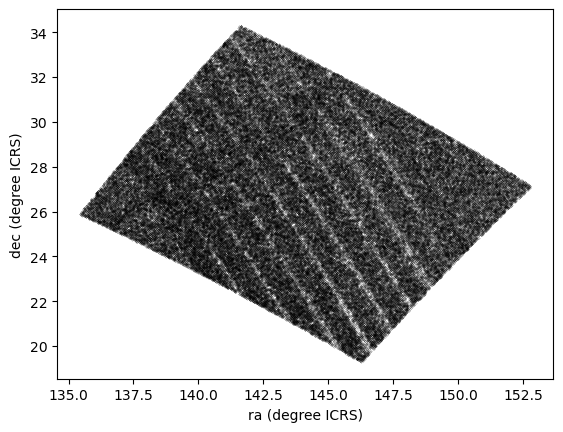

In [5]:
x = polygon_results['ra']
y = polygon_results['dec']
plt.plot(x,y,'ko', alpha=0.6, markersize=0.2)

plt.xlabel('ra (degree ICRS)')
plt.ylabel('dec (degree ICRS)')


In [6]:
distance = 8 * u.kpc
radial_velocity = 0* u.km/u.s
sky_coord=SkyCoord(ra=polygon_results['ra'], 
                  dec=polygon_results['dec'],
                  pm_ra_cosdec=polygon_results['pmra'],
                  pm_dec = polygon_results['pmdec'],
                  distance=distance,
                  radial_velocity=radial_velocity)
transformed = sky_coord.transform_to(gd1_frame)
transformed

<SkyCoord (GD1Koposov10): (phi1, phi2, distance) in (deg, deg, kpc)
    [(-54.97562251, -3.65934904, 8.), (-54.4982471 , -3.08152388, 8.),
     (-54.55163387, -3.55422922, 8.), ..., (-54.94894646, -4.69129505, 8.),
     (-54.87334917, -4.95108083, 8.), (-54.6083886 , -4.85901398, 8.)]
 (pm_phi1_cosphi2, pm_phi2, radial_velocity) in (mas / yr, mas / yr, km / s)
    [(  1.02504998,   3.7333648 , -8.90042666e-09),
     ( -8.59069569,  -9.01671258,  2.41133319e-08),
     (  3.70928841, -19.6109961 ,  4.41214262e-08), ...,
     (-11.15848485,  15.14717644, -3.03262813e-08),
     (-14.19483497,  -1.48230794,  7.45324099e-09),
     ( -1.72375714,   5.97941254, -1.27358082e-08)]>

In [7]:
skycoord_gd1 = reflex_correct(transformed)
skycoord_gd1

<SkyCoord (GD1Koposov10): (phi1, phi2, distance) in (deg, deg, kpc)
    [(-54.97562251, -3.65934904, 8.), (-54.49824711, -3.08152389, 8.),
     (-54.55163387, -3.55422922, 8.), ..., (-54.94894646, -4.69129505, 8.),
     (-54.87334917, -4.95108083, 8.), (-54.6083886 , -4.85901399, 8.)]
 (pm_phi1_cosphi2, pm_phi2, radial_velocity) in (mas / yr, mas / yr, km / s)
    [( 6.42994451,   6.51815743, -85.89847175),
     (-3.16863659,  -6.20679458, -83.12100702),
     ( 9.1294466 , -16.81956952, -84.18853236), ...,
     (-5.75262125,  17.89093031, -87.6914386 ),
     (-8.78623147,   1.25154922, -87.89277153),
     ( 3.69437506,   8.71911075, -86.78009662)]>

Text(0, 0.5, 'phi2 (degree GD1)')

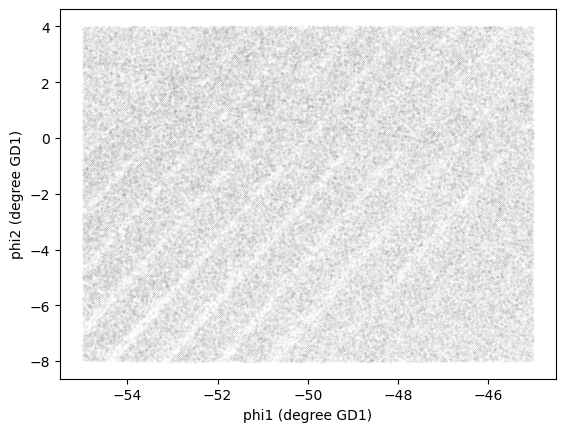

In [8]:
x= skycoord_gd1.phi1
y= skycoord_gd1.phi2
plt.plot(x, y, 'ko', markersize=0.1, alpha=0.2)

plt.xlabel('phi1 (degree GD1)')
plt.ylabel('phi2 (degree GD1)')

In [9]:
polygon_results['phi1']=skycoord_gd1.phi1
polygon_results['phi2']=skycoord_gd1.phi2
polygon_results['pm_phi1'] = skycoord_gd1.pm_phi1_cosphi2
polygon_results['pm_phi2'] = skycoord_gd1.pm_phi2

results_df=polygon_results.to_pandas()
results_df.shape

(140339, 10)

In [10]:
def make_dataframe(table):
    """Transform coordinates from ICRS to GD-1 frame.
    
    table: Astropy Table
    
    returns: Pandas DataFrame
    """
    #Create a SkyCoord object with the coordinates and proper motions
    # in the input table
    skycoord = SkyCoord(
               ra=table['ra'], 
               dec=table['dec'],
               pm_ra_cosdec=table['pmra'],
               pm_dec=table['pmdec'], 
               distance=8*u.kpc, 
               radial_velocity=0*u.km/u.s)

    # Define the GD-1 reference frame
    gd1_frame = GD1Koposov10()

    # Transform input coordinates to the GD-1 reference frame
    transformed = skycoord.transform_to(gd1_frame)

    # Correct GD-1 coordinates for solar system motion around galactic center
    skycoord_gd1 = reflex_correct(transformed)

    #Add GD-1 reference frame columns for coordinates and proper motions
    table['phi1'] = skycoord_gd1.phi1
    table['phi2'] = skycoord_gd1.phi2
    table['pm_phi1'] = skycoord_gd1.pm_phi1_cosphi2
    table['pm_phi2'] = skycoord_gd1.pm_phi2

    # Create DataFrame
    df = table.to_pandas()

    return df


In [11]:
results_df= make_dataframe(polygon_results)

In [12]:
results_table = Table.from_pandas(results_df)
filename = 'gd1_data.hdf'
results_df.to_hdf(filename, 'results_df', mode='w')

/tmp/ipykernel_7105/1359264038.py:3: FutureWarning: Starting with pandas version 3.0 all arguments of to_hdf except for the argument 'path_or_buf' will be keyword-only.
  results_df.to_hdf(filename, 'results_df', mode='w')
